# Analysing statistical workspaces with xRooFit

# 1. Exploring workspaces

This notebook covers how to open a workspace and explore its content using the xRooFit API. All workspace exploration involve using the [xRooNode](https://root.cern.ch/doc/master/classROOT_1_1Experimental_1_1XRooFit_1_1xRooNode.html) class, which provides a high-level API for interacting with RooFit/HS3 workspaces.

In [1]:
import ROOT
ROOT.gSystem.Load("xroofit_build/libxRooFit")
from ROOT.Experimental import XRooFit
ROOT.gROOT.GetVersion() # show version of ROOT

xRooFit -- Create/Explore/Modify Workspaces -- Development ongoing 
                xRooFit : http://gitlab.cern.ch/will/xroofit
                Version: 77eb847 [2024-03-19 10:27:42 +0100]


'6.31/01'

## 1.1. Opening a workspace and listing its content

Start by creating an `xRooNode` from the file:

In [2]:
w = ROOT.xRooNode("Unfolding_dPhi_ttbar_Z_5bins_comb_particle_tau2.4_NORM.json")

Warning in <xRooNode::xRooNode>: Inferring initial errors of 116 parameters (give all nuisance parameters an error to avoid this msg)


You can explore the content of the workspace somewhat like you would a file system: each node contains sub-nodes, which you can interact with to explore ever deeper. Here are some methods we

In [3]:
print("This workspace contains",w["models"].size(),"pdfs (", 
      [m.GetName() for m in w["models"]], ") and",w["datasets"].size(),"datasets (",
      [d.GetName() for d in w["datasets"]],")")
print("There are", w.pars().size(), "parameters and",w.obs().size(),"observables (of which", 
      w.globs().size(),"are global and",w.robs().size(),"are regular)")
print(f"There are currently {w.floats().size()} floating parameters")
print(f"There are {w.poi().size()} parameters of interest:")
w.poi().Print()

This workspace contains 2 pdfs ( ['regularization_dPhi_ttbar_Z', 'simPdf'] ) and 2 datasets ( ['asimovData', 'obsData'] )
There are 470 parameters and 360 observables (of which 350 are global and 10 are regular)
There are currently 357 floating parameters
There are 4 parameters of interest:
Unfolding_dPhi_ttbar_Z_5bins_comb_particle_tau2.4_NORM.json/.poi: RooArgList::Unfolding_dPhi_ttbar_Z_5bins_comb_particle_tau2.4_NORM.json.poi
0) dPhi_ttbar_Z_Bin_001_mu : RooRealVar::dPhi_ttbar_Z_Bin_001_mu = 1  L(0 - 2) 
1) dPhi_ttbar_Z_Bin_002_mu : RooRealVar::dPhi_ttbar_Z_Bin_002_mu = 1  L(0 - 2) 
2) dPhi_ttbar_Z_Bin_003_mu : RooRealVar::dPhi_ttbar_Z_Bin_003_mu = 1  L(0 - 2) 
3) dPhi_ttbar_Z_Bin_004_mu : RooRealVar::dPhi_ttbar_Z_Bin_004_mu = 1  L(0 - 2) 


Note that subnodes can be accessed either by name or index. 

## 1.2. Accessing bin contents and uncertainties

Let us now explore the contents and uncertainties of a pdf in the workspace:

In [4]:
for chan in w["models"]["simPdf"].bins(): # the 'bins' method will return the channels of a pdf if it is a multi-channel pdf (which simPdf is)
    print(chan.GetName(),": rob=",chan.robs()[0].GetName(), " , n_globs=", chan.globs().size()) #number of globs typically indicates number of systematics
    for i,bin in enumerate(chan.bins()):
        print("  bin",i,": content=",bin.GetContent(),"+/-",bin.GetError()," obsData=",bin.GetData("obsData"))
        if i==0: # we print the 'samples' (components) of just the first bin, to save on overprinting
            for samp in chan["samples"].components():
                print("    ",samp.GetName(),":",samp.bins()[0].GetContent(),"+/-",samp.bins()[0].GetError())

channelCat=reg_3l_ttZ : rob= obs_x_reg_3l_ttZ  , n_globs= 190
  bin 0 : content= 91.72166184275326 +/- 6.464007798506465  obsData= 108.0
     model_reg_3l_ttZ_WZb_shapes : 3.518642692078117 +/- 0.8948561987541364
     model_reg_3l_ttZ_WZc_shapes : 1.4433443114935471 +/- 0.5940116316365228
     model_reg_3l_ttZ_WZl_shapes : 0.17640714546723757 +/- 0.07719884069073976
     model_reg_3l_ttZ_ZZb_shapes : 0.7012360206313558 +/- 0.2231013369628657
     model_reg_3l_ttZ_ZZc_shapes : 0.1602072726636834 +/- 0.05113129352746797
     model_reg_3l_ttZ_ZZl_shapes : 0.0596180630109302 +/- 0.018568687410200235
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_1_shapes : 44.84818846861233 +/- 2.654479100071728
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_2_shapes : 9.55862408007654 +/- 0.7919084217030636
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_3_shapes : 5.648198393767563 +/- 0.5803313221516241
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_4_shapes : 3.148044

## 1.3. Visualizing the workspace

The whole model can also be visualized using the following methods:

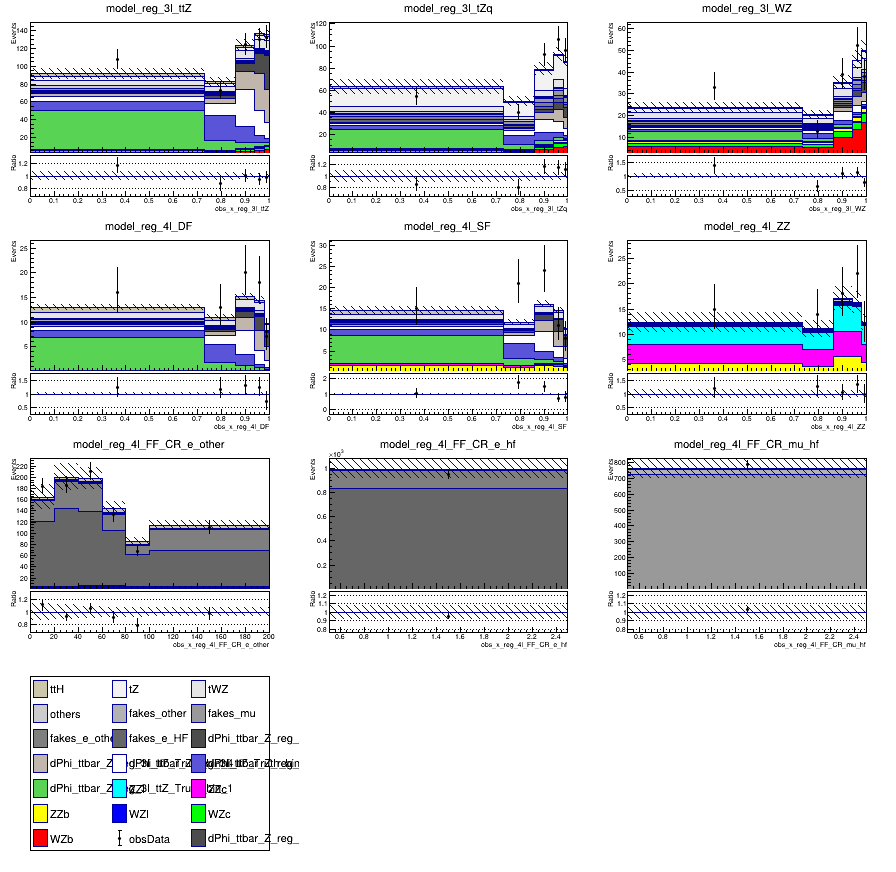

In [16]:
w["datasets/obsData"].SetChecked();w["datasets/asimovData"].SetChecked(False) # selects which datasets to display with the pdf
ROOT.gStyle.SetOptStat(False) # turn off the stats-box that ROOT will display by default on every plot
c = ROOT.TCanvas("canv","canv",900,900)
ROOT.gStyle.SetLegendFont(43);ROOT.gStyle.SetLegendTextSize(12);
w["models/simPdf"].Draw("eratio") # draw model with error bars and ratio plot
c.Draw()

# 2. Modifying workspaces

Workspaces can be modified 'in-situ' or a new workspace can be created and objects added to it. We will see an example of both of these now ...

## 2.1. Modifying in-situ: Reparameterizing a parameter

We can use the `xRooNode::Replace` method to replace any variable with a generic function. The function must follow RooFit's [WS-factory language](https://root.cern.ch/doc/master/classRooFactoryWSTool.html#a228d9cb336a3bdc7dfe260f4c6aaf8df). For example:

In [6]:
poiName = w.poi()[0].GetName() # get the name of the first POI
w.poi()[0].Replace(f"expr::myFunc('2*{poiName}',{poiName})") # example of replacing the parameter everywhere in the workspace with a function that multiplies it by 2

# we can save this modified workspace like this:
w.SaveAs("reparameterized_ws.root")

# restore the state of the workspace by replacing the function again with the original poi
# Can get a list of all functions in a workspace using the `factors()` method on the workspace:
w.factors()["myFunc"].Replace(poiName) #if you were to now Print the workspace, `myFunc` will appear in the 'scratch' folder, because it isn't part of a pdf any more

xRooNode{}

Warning in <xRooNode::Replace>: Replacing dPhi_ttbar_Z_Bin_001_mu in all clients: dPhi_ttbar_Z_Bin_005_mu,mu_prime_2,model_reg_3l_WZ_dPhi_ttbar_Z_reg_3l_WZ_Truth_bin_1_scaleFactors,model_reg_3l_tZq_dPhi_ttbar_Z_reg_3l_tZq_Truth_bin_1_scaleFactors,model_reg_4l_DF_dPhi_ttbar_Z_reg_4l_DF_Truth_bin_1_scaleFactors,model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_1_scaleFactors,model_reg_4l_SF_dPhi_ttbar_Z_reg_4l_SF_Truth_bin_1_scaleFactors,model_reg_4l_ZZ_dPhi_ttbar_Z_reg_4l_ZZ_Truth_bin_1_scaleFactors,
Info in <xRooNode::SaveAs>: workspace saved to reparameterized_ws.root
Warning in <xRooNode::Replace>: Replacing myFunc in all clients: dPhi_ttbar_Z_Bin_005_mu,mu_prime_2,model_reg_3l_WZ_dPhi_ttbar_Z_reg_3l_WZ_Truth_bin_1_scaleFactors,model_reg_3l_tZq_dPhi_ttbar_Z_reg_3l_tZq_Truth_bin_1_scaleFactors,model_reg_4l_DF_dPhi_ttbar_Z_reg_4l_DF_Truth_bin_1_scaleFactors,model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_1_scaleFactors,model_reg_4l_SF_dPhi_ttbar_Z_reg_4l_SF_Truth_bin_1_scaleFactors

## 2.2. Creating a new workspace: Selecting a subset of the channels

We can use the `xRooNode::reduced` method to create a shallow-copy of a multi-channel pdf for a subset of the channels. This new pdf is not added to the workspace (but it can be), but we will show how we can instead add it to a new workspace, along with the obsData associated to the selected channels:

In [7]:
newModel = w["models/simPdf"].reduced("reg_3l_ttZ,reg_4l_*") # specify subset of channels as comma separated list, note you can use wildcards.
print("There are",newModel.bins().size(),"channels in reduced model")

# we can save this reduced pdf to a workspace of its own, if we wish ....
w2 = ROOT.xRooNode("RooWorkspace","newws","my new workspace") # Creates a new RooWorkspace (name=newws,title=my new workspace), wrapped by an xRooNode
w2.Add(newModel) # note: workspaces create an owned copy of things that get added to them
w2.Add(newModel.datasets()["obsData"]) # also add the subset of the obsData dataset that is relevant to newModel
w2.Print() # inspect the content of this workspace before saving
w2.SaveAs("reduced_ws.root") # BUG: json serializer currently crashing, so can only save as a ROOT file at the moment

There are 7 channels in reduced model
[#1] INFO:ObjectHandling -- RooWorkspace::import(newws) importing dataset obsData
newws: RooWorkspace::newws
!models
 0) simPdf_reduced : RooSimultaneous::simPdf_reduced
!datasets
 1) obsData : RooDataSet::obsData[channelCat,obs_x_reg_3l_ttZ,obs_x_reg_4l_DF,obs_x_reg_4l_FF_CR_e_hf,obs_x_reg_4l_FF_CR_e_other,obs_x_reg_4l_FF_CR_mu_hf,obs_x_reg_4l_SF,obs_x_reg_4l_ZZ,weight:weight] = 28 entries (3430 weighted)


Info in <xRooNode::SaveAs>: newws saved to reduced_ws.root


# 3. Constructing NLL Functions

An NLL function (the objective function to be minimized) is constructed from a pdf and a dataset using the `xRooNode::nll` method. 

## 3.1. Choose which parameters to float

While this isn't strictly necessary to do before constructing the NLL function, there are certain **constant term optimizations** that can be performed if you first mark constant any parameter you plan to hold constant during any fit(s). For this example we will only float the poi and a subset of the nuisance parameters:

In [8]:
w.pars().setAttribAll("Constant") # marks all parameters constant
w.poi().setAttribAll("Constant",False) # re-floats all the poi
w.pars().reduced("alpha_EG*,gamma_stat_reg_4l_SF*").setAttribAll("Constant",False) # re-floats some nuisance parameters (usually represent systematics)
print("There are",w.floats().size(),"floating parameters")

There are 12 floating parameters


## 3.2. Select NLL Options

There are a number of NLL-construction options available, [listed here](https://root.cern.ch/doc/master/classRooAbsPdf.html#a24b1afec4fd149e08967eac4285800de). The NLL options can be assembled as follows:

In [17]:
nllOpts = ROOT.xRooFit.createNLLOptions() # use the default xRooFit options as a starting point (enables offsetting, and disables const-term optimization)
nllOpts.Add(ROOT.RooFit.ExternalConstraints(w.pdf("regularization_dPhi_ttbar_Z")).Clone()) # add second pdf as the regularization term for the NLL
nllOpts.Add(ROOT.RooFit.EvalBackend("legacy").Clone()) # use legacy backend evaluation method

## 3.3. Constructing the NLL with a pdf, dataset, and NLL Options list

Now you can create the NLL function for your chosen pdf. If you pass "" as the dataset name an asimov dataset corresponding to the current state of the model will be used. 

In [10]:
nll = w["models/simPdf"].nll("obsData",nllOpts)
nll.Print() # Prints the PDF, Dataset, NLL Options, and Fit Config

PDF: RooSimultaneous::simPdf[ indexCat=channelCat reg_3l_WZ=model_reg_3l_WZ reg_3l_tZq=model_reg_3l_tZq reg_3l_ttZ=model_reg_3l_ttZ reg_4l_DF=model_reg_4l_DF reg_4l_FF_CR_e_hf=model_reg_4l_FF_CR_e_hf reg_4l_FF_CR_e_other=model_reg_4l_FF_CR_e_other reg_4l_FF_CR_mu_hf=model_reg_4l_FF_CR_mu_hf reg_4l_SF=model_reg_4l_SF reg_4l_ZZ=model_reg_4l_ZZ ] = 0.119548
Data: RooDataSet::obsData[channelCat,obs_x_reg_3l_WZ,obs_x_reg_3l_tZq,obs_x_reg_3l_ttZ,obs_x_reg_4l_DF,obs_x_reg_4l_FF_CR_e_hf,obs_x_reg_4l_FF_CR_e_other,obs_x_reg_4l_FF_CR_mu_hf,obs_x_reg_4l_SF,obs_x_reg_4l_ZZ,weight:weight] = 38 entries (3993 weighted)
NLL Options: 
 GlobalObservablesSource : model
 OffsetLikelihood : 1
 Optimize : 0
 ExternalConstraints : regularization_dPhi_ttbar_Z
 EvalBackend : 0
 GlobalObservables : nom_alpha_BTag_B_0,nom_alpha_BTag_B_1,nom_alpha_BTag_B_10,nom_alpha_BTag_B_11,nom_alpha_BTag_B_12,nom_alpha_BTag_B_13,nom_alpha_BTag_B_14,nom_alpha_BTag_B_15,nom_alpha_BTag_B_16,nom_alpha_BTag_B_17,nom_alpha_BTag_B_1

## 3.4. Evaluating the NLL function

The NLL function can be evaluated while varying some of the parameters of the model:

In [11]:
import numpy as np
poi = w.poi()[0]
startVal = poi.getVal()
for val in np.linspace(poi.getMin(),poi.getMax(),10): # scan from min to max allowed value
    poi.setVal(val)
    print(poi.GetName(),"=",val," nll=",nll.getVal())
poi.setVal(startVal) # reset value

dPhi_ttbar_Z_Bin_001_mu = 0.0  nll= 9511.889887190646
dPhi_ttbar_Z_Bin_001_mu = 0.2222222222222222  nll= 9491.954732711303
dPhi_ttbar_Z_Bin_001_mu = 0.4444444444444444  nll= 9477.590868539133
dPhi_ttbar_Z_Bin_001_mu = 0.6666666666666666  nll= 9467.839443849427
dPhi_ttbar_Z_Bin_001_mu = 0.8888888888888888  nll= 9462.106333762014
dPhi_ttbar_Z_Bin_001_mu = 1.1111111111111112  nll= 9460.019964270667
dPhi_ttbar_Z_Bin_001_mu = 1.3333333333333333  nll= 9461.358980950059
dPhi_ttbar_Z_Bin_001_mu = 1.5555555555555554  nll= 9466.01480265484
dPhi_ttbar_Z_Bin_001_mu = 1.7777777777777777  nll= 9473.974311478687
dPhi_ttbar_Z_Bin_001_mu = 2.0  nll= 9485.316708851196
[#1] INFO:Minimization -- RooNLLVar::evaluatePartition(reg_3l_WZ) first = 0 last = 5 Likelihood offset now set to 405.768
[#1] INFO:Minimization -- RooNLLVar::evaluatePartition(reg_3l_tZq) first = 0 last = 5 Likelihood offset now set to 870.406
[#1] INFO:Minimization -- RooNLLVar::evaluatePartition(reg_3l_ttZ) first = 0 last = 5 Likelihood

# 4. NLL Minimization

## 4.1. Running an inidividual minimization

Before running the first minimization with the NLL, the **fit config** should be set as required using both the `nll.fitConfig().MinimizerOptions()` and `nll.fitConfigOptions().SetValue("optName",...)` methods (the latter is used for the 'specific' options). For example, to strange the minimization strategy starting value, you can do: `nll.fitConfig().MinimizerOptions().SetStrategy(...)`. To change the Hesse strategy you can do `nll.fitConfigOptions().SetValue("HesseStrategy",...)`


In [12]:
fr = nll.minimize()
print("Fit status (0=good):",fr.status(),", Covariance Quality (3=good):",fr.covQual())
assert(fr.status()==0);assert(fr.covQual()==3) # just to check results are good

for p in fr.floatParsFinal():
    print(p.GetName(),"=",p.getVal(),"+/-",p.getError())

Fit status (0=good): 0 , Covariance Quality (3=good): 3
alpha_EG_RESOLUTION_ALL = -0.029312115905352928 +/- 0.9939953733320105
alpha_EG_SCALE_AF2 = -0.0009519399650241137 +/- 0.9949732087431793
alpha_EG_SCALE_ALL = -0.36719110948036393 +/- 0.912035870320304
dPhi_ttbar_Z_Bin_001_mu = 1.107660255162599 +/- 0.1525940620366703
dPhi_ttbar_Z_Bin_002_mu = 1.023806140479727 +/- 0.15007939853112867
dPhi_ttbar_Z_Bin_003_mu = 1.0667853073687743 +/- 0.15165733463079056
dPhi_ttbar_Z_Bin_004_mu = 0.9742966335054583 +/- 0.1332230807500805
gamma_stat_reg_4l_SF_bin_0 = 0.999939693668093 +/- 0.020884706553448873
gamma_stat_reg_4l_SF_bin_1 = 1.0017822343118143 +/- 0.025852370180388662
gamma_stat_reg_4l_SF_bin_2 = 1.0009588864171526 +/- 0.02059732327718905
gamma_stat_reg_4l_SF_bin_3 = 0.9995303336144047 +/- 0.02205225686170753
gamma_stat_reg_4l_SF_bin_4 = 0.9995817635963554 +/- 0.02814640796176049


## 4.2. Post-fit model visualization

After the minimization, the model parameters and uncertainties have become set to the post-fit values. However, the correlations between the parameters is not yet set in the workspace. This must be done explicitly before obtaining any model yield errors. Note that all parameters that were held constant in the fit will no longer contribute to the uncertainties in the model (even if they have an error value). 

This is done using `xRooNode::SetFitResult`:

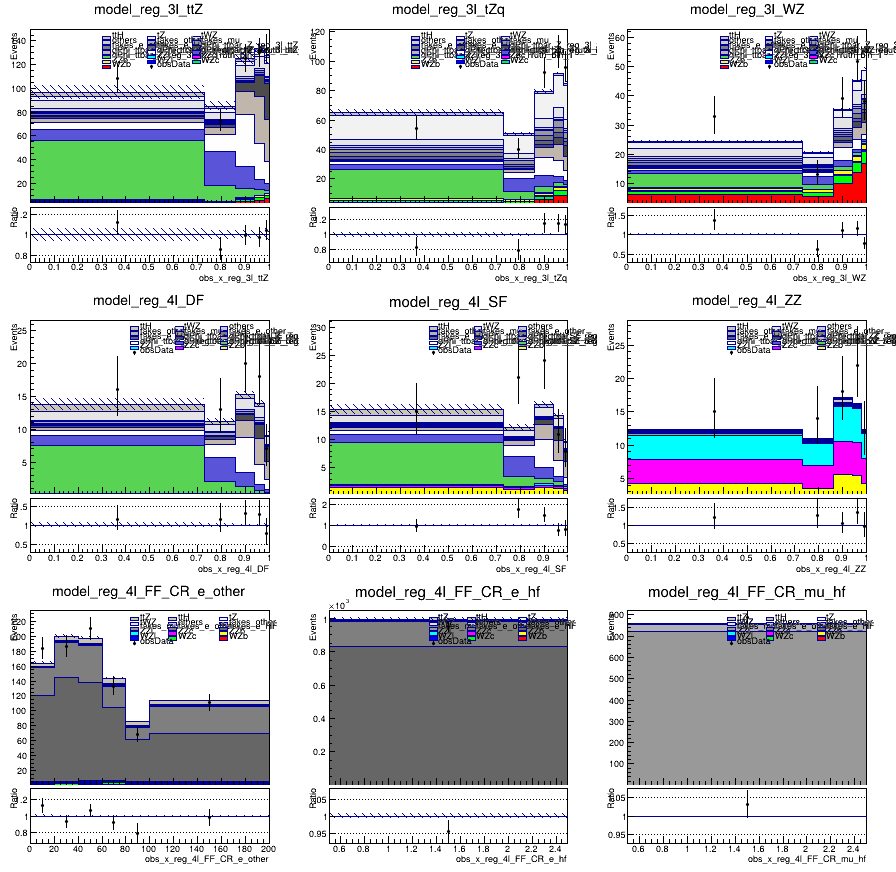

In [13]:
w.SetFitResult(fr) # ensures post-fit parameter values, uncertainties, and correlations are available to the model when calculating yields and errors
c = ROOT.TCanvas("canv","canv",900,900);w["models/simPdf"].Draw("eratio");c.Draw() # redraw model

## 4.3. Calculating Impact

Impact is a way to describe the correlation between two parameters. It can be estimated using the correlation matrix, but the full calculation involves running the fit with the second parameter moved to its +/- 1 sigma values (using if prefit or postfit uncertainties) and evaluating the change in the best-fit value of the first parameter. Here's how to get the approx values (change `approx` to `False` to do the full calculation):

In [14]:
poiName = w.poi()[0].GetName(); npName = w.np().floats()[0].GetName()
print(f"Hessian post-fit impact of {npName} on {poiName}:",
      fr.impact(poiName,npName,up=True,prefit=False,approx=True),
      fr.impact(poiName,npName,up=False,prefit=False,approx=True) ) # change prefit to True for pre-fit impact

Hessian post-fit impact of alpha_EG_RESOLUTION_ALL on dPhi_ttbar_Z_Bin_001_mu: -0.0001886165868077384 0.0001886165868077384


All the approximated impacts can be visualized in an impact plot:

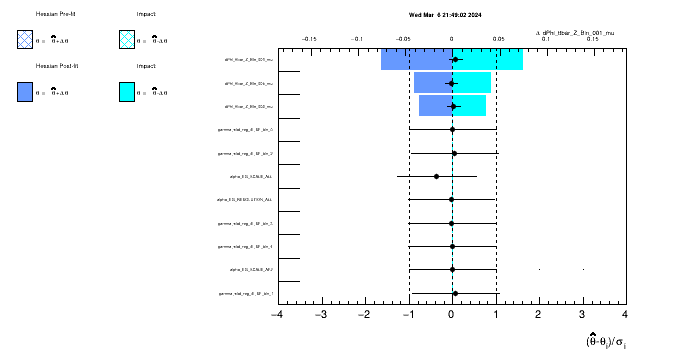

In [15]:
c = ROOT.TCanvas("impact","impact",700,160+20*(fr.floatParsFinal().size()-1)) # ensures height of canvas enough for params
fr.Draw(f"impact:{poiName}") # draw 'hessian' impact plot for poi
c.Draw()

## 4.4. Calculating Conditional Uncertainties

The conditional uncertainty on a parameter is the uncertainty that parameter has if the parameters it is conditioned on were held constant. The difference (in quadrature) to the total uncertainty is often quoted as the component of the total uncertainty due to the conditioned parameters. If we condition on all the parameters we obtain the stat-only uncertainty.

In [16]:
for poi in w.poi():
    totErr = fr.floatParsFinal().find(poi.GetName()).getError()
    statErr = fr.conditionalError(poi.GetName(),"*",up=True,approx=True)
    systErr = ROOT.TMath.Sqrt(ROOT.TMath.Power(totErr,2) - ROOT.TMath.Power(statErr,2))
    print(poi.GetName(),":",poi.getVal(),"+/-",statErr,"(stat) +/-",systErr,"(syst)")

dPhi_ttbar_Z_Bin_001_mu : 1.107660255162599 +/- 0.11974188197736223 (stat) +/- 0.09458768138278179 (syst)
dPhi_ttbar_Z_Bin_002_mu : 1.023806140479727 +/- 0.12827840856370482 (stat) +/- 0.07790042207734543 (syst)
dPhi_ttbar_Z_Bin_003_mu : 1.0667853073687743 +/- 0.13145475552929786 (stat) +/- 0.07562800007965383 (syst)
dPhi_ttbar_Z_Bin_004_mu : 0.9742966335054583 +/- 0.11179095920906883 (stat) +/- 0.07246496176538544 (syst)


## 4.5. Running a profile likelihood scan

A series of conditional fits are required for a profile likelihood scan. This can be accomplished using an `xRooHypoSpace` which is an object designed for hypothesis testing, where profile likelihood test-statistics are commonly used:

In [17]:
poiName = w.poi()[0].GetName()
mu_hat = fr.floatParsFinal().find(poiName) # the best-fit value ... will use to define the range of the scan
hs = nll.hypoSpace(poiName) # create a 1d hypothesis space with the given parameter
hs.scan("plr",10,mu_hat.getVal() - mu_hat.getError()*3, mu_hat.getVal() + mu_hat.getError()*3) # scan 10 points
for hp in hs:
    print(poiName,"=",hp.fNullVal(),", plr = ",hp.ts_asymp().first,"+/-",hp.ts_asymp().second) #ts stands for test-statistic
    # if the conditional fit failed, the ts value will be a nan ... can look get some more info about status code of fit from printing hypoPoint
    if ROOT.TMath.IsNaN(hp.ts_asymp().first): hp.Print()

dPhi_ttbar_Z_Bin_001_mu = 0.649878 , plr =  9.625506345997564 +/- 2.2390938075375138e-07
dPhi_ttbar_Z_Bin_001_mu = 0.751607 , plr =  5.718830333291407 +/- 2.0514740931181766e-07
dPhi_ttbar_Z_Bin_001_mu = 0.853337 , plr =  2.8684216967485554 +/- 2.0511463633775221e-07
dPhi_ttbar_Z_Bin_001_mu = 0.955066 , plr =  1.016106774291984 +/- 2.051052984198501e-07
dPhi_ttbar_Z_Bin_001_mu = 1.0568 , plr =  0.1111962630857306 +/- 1.6281702748411725e-05
dPhi_ttbar_Z_Bin_001_mu = 1.15852 , plr =  0.10953933807104477 +/- 1.174393808577119e-05
dPhi_ttbar_Z_Bin_001_mu = 1.26025 , plr =  0.9725320010584255 +/- 6.417388308798275e-06
dPhi_ttbar_Z_Bin_001_mu = 1.36198 , plr =  2.6664989455493924 +/- 5.996217408885103e-06
dPhi_ttbar_Z_Bin_001_mu = 1.46371 , plr =  5.16194567875209 +/- 9.81434779116072e-06
dPhi_ttbar_Z_Bin_001_mu = 1.56544 , plr =  8.433098683181015 +/- 2.2624052808232165e-05
[#1] INFO:Eval -- RooRealVar::setRange(dPhi_ttbar_Z_Bin_001_mu) new range named 'scan' created with bounds [0.649878,1

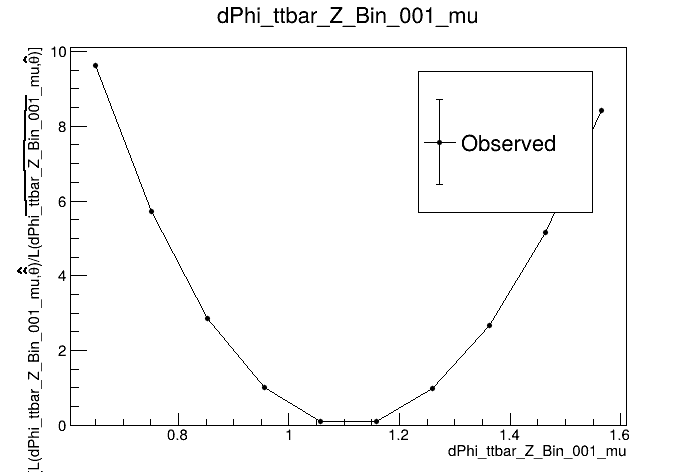

In [18]:
# can also just plot the hypoSpace:
c = ROOT.TCanvas()
hs.Draw()
c.Draw()